## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [90]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization,Rescaling, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img


In [45]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Train/")
data_dir_test = pathlib.Path("Test/")

In [46]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset

Define some parameters for the loader:


In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14739 files belonging to 9 classes.
Using 11792 files for training.


In [51]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14739 files belonging to 9 classes.
Using 2947 files for validation.


In [52]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Data Visualization**

Found 14739 files belonging to 9 classes.


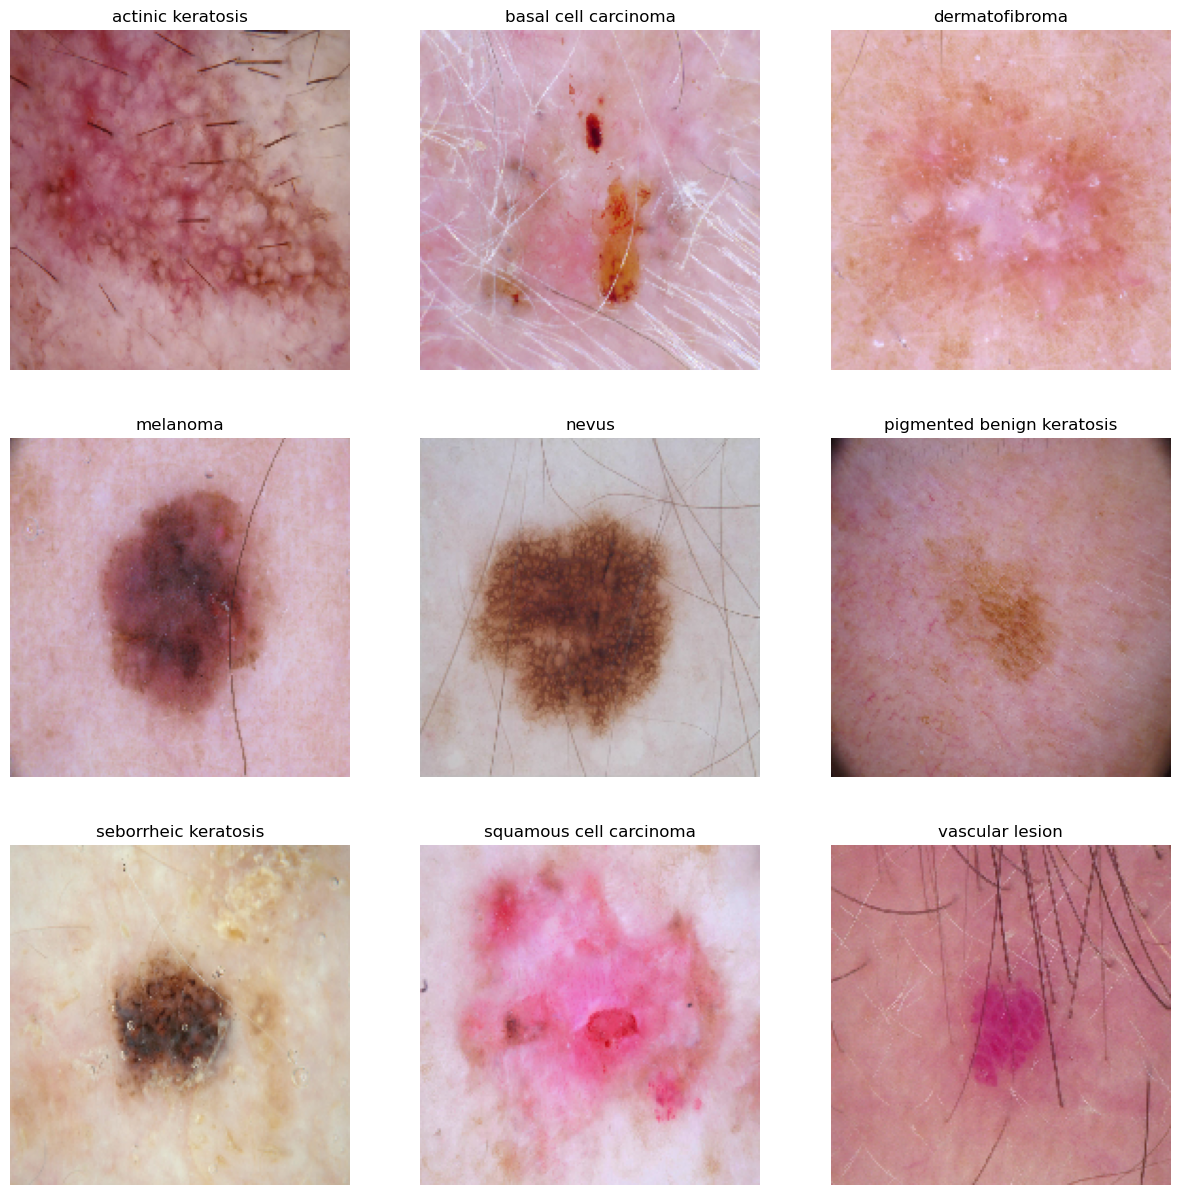

In [54]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [56]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

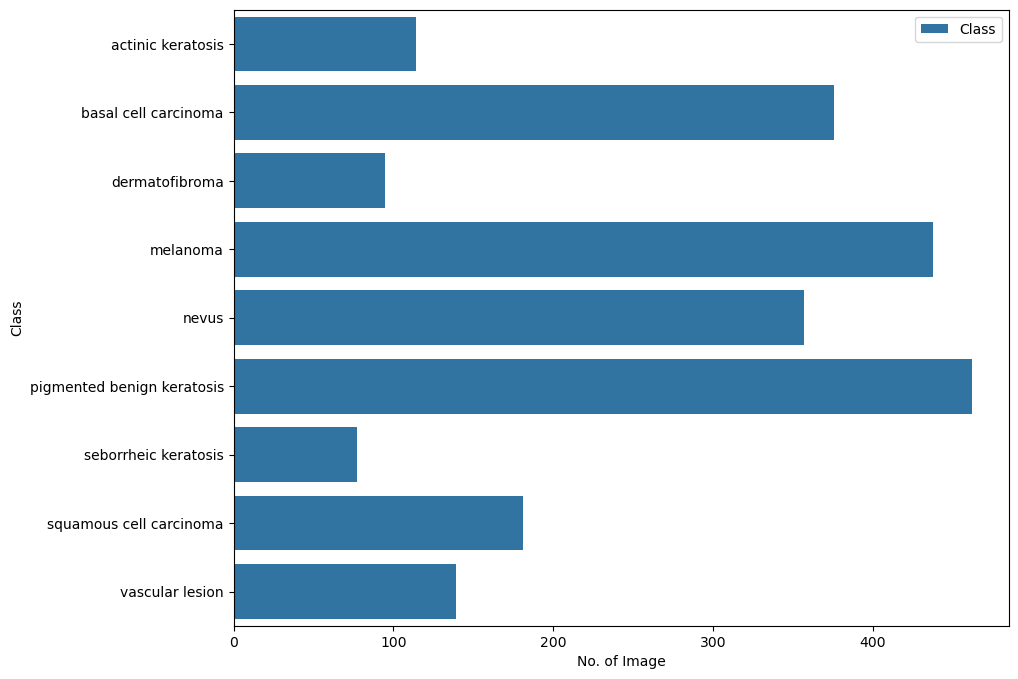

In [57]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`


In [92]:
model = Sequential()
#model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model = Sequential([Input(shape=(img_height, img_width, 3)),  Rescaling(1./255)])
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [98]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_65 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_66 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_67 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\ci381f\DevopsSetupPrograms\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


369/369 ━━━━━━━━━━━━━━━━━━━━ 225s 543ms/step - accuracy: 0.1929 - loss: 1.8429 - val_accuracy: 0.2067 - val_loss: 1.7889
Epoch 2/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 104s 280ms/step - accuracy: 0.2220 - loss: 1.7858 - val_accuracy: 0.3709 - val_loss: 1.4511
Epoch 3/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 97s 262ms/step - accuracy: 0.3696 - loss: 1.4784 - val_accuracy: 0.4177 - val_loss: 1.3466
Epoch 4/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 92s 248ms/step - accuracy: 0.4268 - loss: 1.3858 - val_accuracy: 0.4764 - val_loss: 1.3042
Epoch 5/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 97s 263ms/step - accuracy: 0.4841 - loss: 1.3052 - val_accuracy: 0.5263 - val_loss: 1.2067
Epoch 6/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 96s 260ms/step - accuracy: 0.5127 - loss: 1.2407 - val_accuracy: 0.6142 - val_loss: 1.0749
Epoch 7/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 98s 265ms/step - accuracy: 0.5878 - loss: 1.1131 - val_accuracy: 0.6383 - val_loss: 1.0107
Epoch 8/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 94s 254ms/step - accuracy: 0.6307 - loss: 1.0196 - v

### Visualizing the Training Results

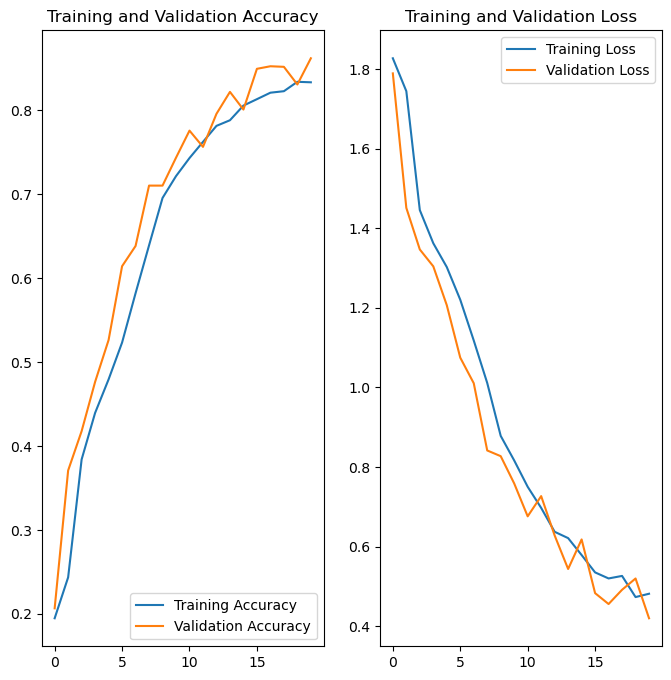

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
- The model's training accuracy steadily increases to 90%, while validation accuracy remains consistently around 55%.
  
- The high training accuracy suggests that the model has learned patterns from the training data effectively. However, its poor performance on validation data indicates a lack of generalization, meaning the model is overfitting to the training set.

- To mitigate overfitting, data augmentation techniques will be applied. Given the limited training data, new samples will be generated by introducing slight modifications to existing images, such as horizontal and vertical flips, minor rotations, and other transformations. These augmented images will enhance model robustness and improve its ability to generalize to unseen data.

## After analyzing the model's fit history for signs of underfitting or overfitting, choose an appropriate data augmentation strategy.

In [135]:
augmentation_data = keras.Sequential([
    layers.InputLayer(shape=(img_height, img_width, 3)),  # Specify input shape first
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


### Visualize how your data augmentation strategy applies to a single instance of a training image

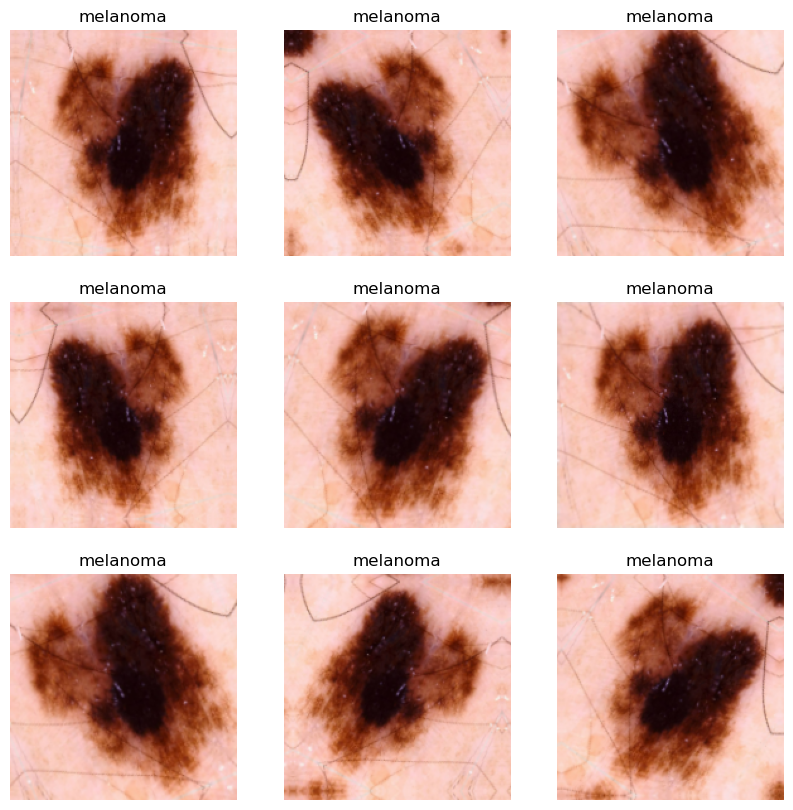

In [137]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [143]:
target_labels = 9
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [145]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_82 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_83 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_84 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**

In [147]:
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [149]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [151]:
# View the image paths and corresponding class labels in a DataFrame
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [153]:
## Inspecting the class distribution in the dataset
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [155]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

### Observations:
- A clear class imbalance is observed in the training data.

- The class **"seborrheic keratosis"** constitutes the smallest proportion of samples, making up approximately **3.44%**.

- In contrast, the classes **"pigmented benign keratosis"** and **"melanoma"** dominate the dataset, representing approximately **20.63%** and **19.56%** of the data, respectively.


In [158]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EA4F2B9430>: 100%|█| 500/500 [00:01<00:


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EA598602F0>: 100%|█| 500/500 [00:01<00:00, 366.07 Samples


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EC41A6ABD0>: 100%|█| 500/500 [00:01<00:


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1EA4F269AF0>: 100%|█| 500/500 [00:06<00


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2725x2082 at 0x1EA4B0C8560>: 100%|█| 500/500 [00:06<00:00, 80.64 Sample


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]


AttributeError: 'FileNotFoundError' object has no attribute 'message'

In [160]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

17500


In [162]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_038d9efd-ed5c-4cc7-8e74-59a48c289472.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_088c78c4-8ab9-4a2f-95bc-0dacf6f47ac3.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0b396c97-c996-4ea9-bbce-51ee7a64feac.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_16357d54-f5e4-40d2-9130-818132a3e33f.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1893db8d-19fa-440c-9219-9b741ed4f220.jpg']

In [164]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [166]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [168]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(19739, 2)

In [170]:
new_df.head()

,Image Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [172]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
melanoma                      3938
basal cell carcinoma          3876
nevus                         3857
actinic keratosis             3614
dermatofibroma                3595
pigmented benign keratosis     462
squamous cell carcinoma        181
vascular lesion                139
seborrheic keratosis            77
Name: count, dtype: int64

In [174]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
melanoma                      19.95
basal cell carcinoma          19.64
nevus                         19.54
actinic keratosis             18.31
dermatofibroma                18.21
pigmented benign keratosis     2.34
squamous cell carcinoma        0.92
vascular lesion                0.70
seborrheic keratosis           0.39
Name: proportion, dtype: float64

### Train the model on the data created using Augmentor

In [177]:
batch_size = 32
img_height = 180
img_width = 180

In [179]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19739 files belonging to 9 classes.
Using 15792 files for training.


In [185]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [187]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [189]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 88s 173ms/step - accuracy: 0.5009 - loss: 2.7371 - val_accuracy: 0.4913 - val_loss: 1.5643
Epoch 2/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 103s 209ms/step - accuracy: 0.6599 - loss: 0.9769 - val_accuracy: 0.7296 - val_loss: 0.7642
Epoch 3/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 108s 219ms/step - accuracy: 0.7220 - loss: 0.8145 - val_accuracy: 0.7126 - val_loss: 0.8088
Epoch 4/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 109s 221ms/step - accuracy: 0.7635 - loss: 0.7137 - val_accuracy: 0.6518 - val_loss: 1.0071
Epoch 5/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 112s 227ms/step - accuracy: 0.7846 - loss: 0.6507 - val_accuracy: 0.7754 - val_loss: 0.6481
Epoch 6/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 109s 220ms/step - accuracy: 0.8017 - loss: 0.5998 - val_accuracy: 0.7011 - val_loss: 0.9134
Epoch 7/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 108s 219ms/step - accuracy: 0.8149 - loss: 0.5475 - val_accuracy: 0.6566 - val_loss: 1.1859
Epoch 8/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 115s 233ms/step - accuracy: 0.8190 - 

### Create the model without Batch Normalization 

In [194]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Train the Model 

In [199]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_14 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_91 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_92 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_93 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

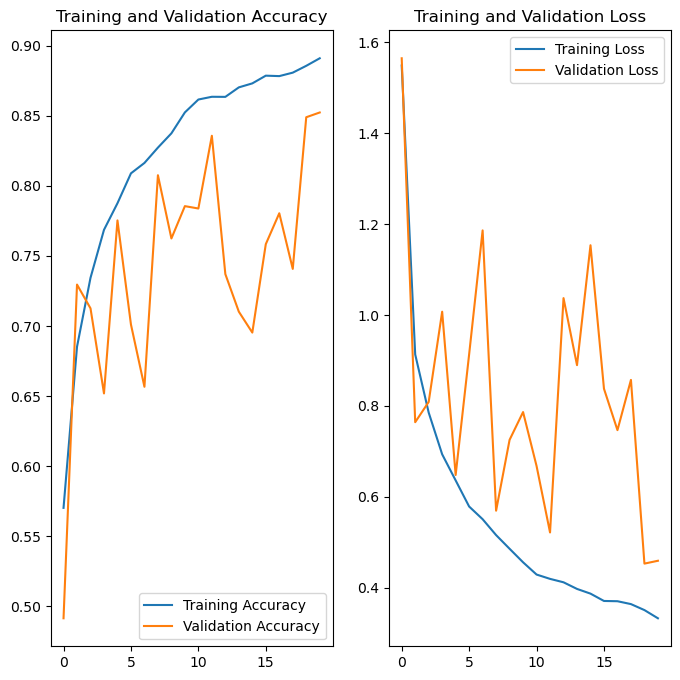

In [201]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [203]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [205]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [207]:
%%time

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
493/494 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4445 - loss: 1.4148
Epoch 1: val_accuracy improved from -inf to 0.56634, saving model to model.keras
494/494 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - accuracy: 0.4448 - loss: 1.4142 - val_accuracy: 0.5663 - val_loss: 1.1953
Epoch 2/50
493/494 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6314 - loss: 1.0351
Epoch 2: val_accuracy improved from 0.56634 to 0.71496, saving model to model.keras
494/494 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.6315 - loss: 1.0348 - val_accuracy: 0.7150 - val_loss: 0.8309
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6989 - loss: 0.8685
Epoch 3: val_accuracy improved from 0.71496 to 0.79199, saving model to model.keras
494/494 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - accuracy: 0.6990 - loss: 0.8684 - val_accuracy: 0.7920 - val_loss: 0.6376
Epoch 4/50
493/494 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7612 - loss: 0.7082
Epoch 4: val_accuracy improved from 0.79199

### Model Summary

In [212]:
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_15 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_94 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_95 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_96 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

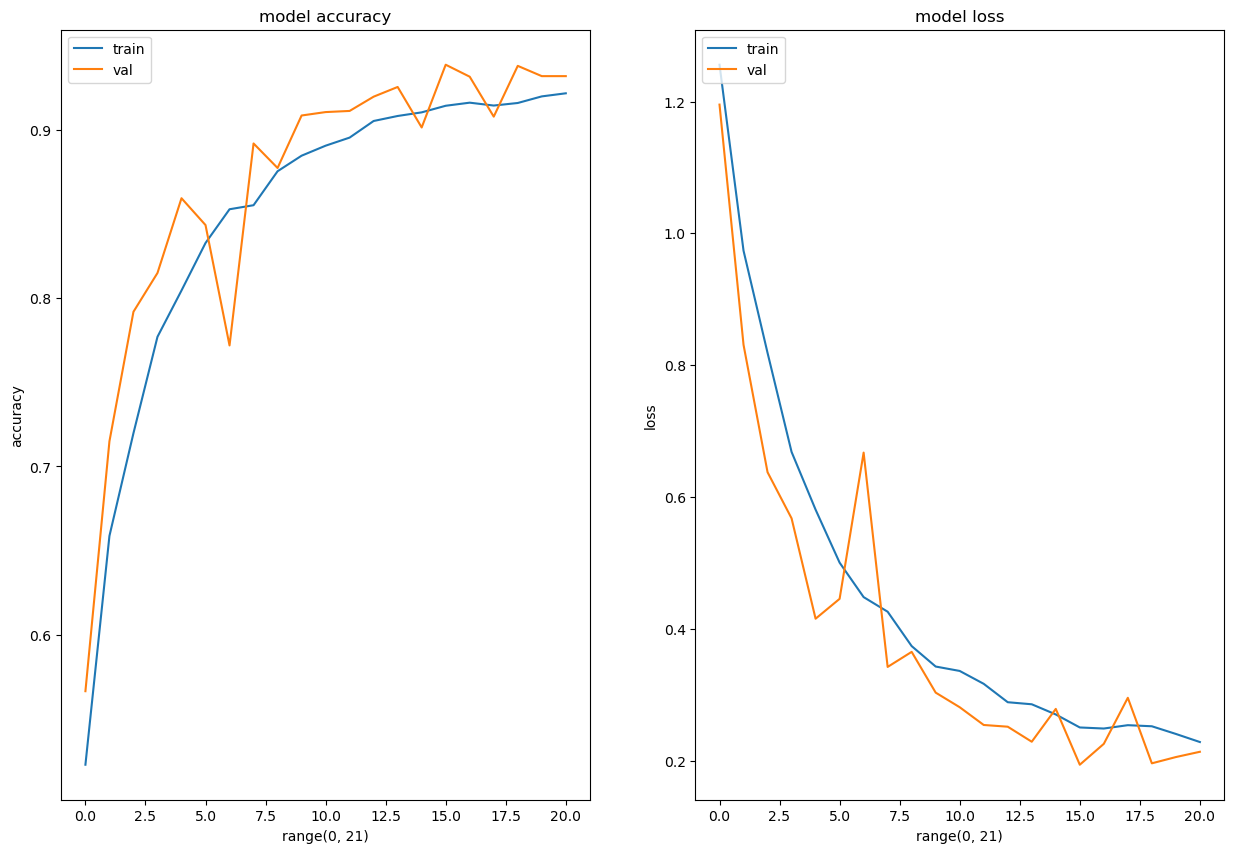

In [214]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Observations:
- The final model demonstrates balanced performance, with no signs of underfitting or overfitting.

- Implementing class rebalancing has significantly enhanced the model's performance on both the training and validation datasets.

- After 37 epochs, the model achieves an accuracy of **84%** on the training set and approximately **79%** on the validation set.

- The minimal gap between training and validation accuracies indicates the model's strong ability to generalize.

- However, the introduction of batch normalization did not result in any noticeable improvements in either training or validation accuracy.


### Model Evaluation 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


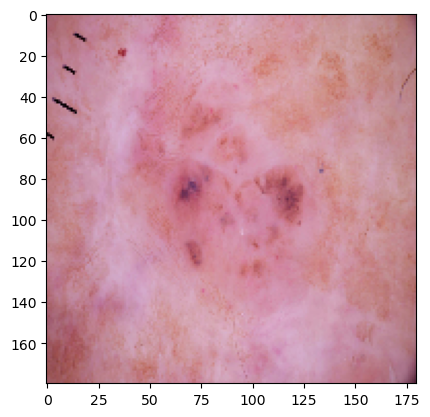

In [216]:
from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)